# Baseline Case definition

In [1]:
from test_utils.imports import *

### Load Basic Guitar dataset data
* This part is not reproducible as the dataset is not publicly available.

In [2]:
MC_base_path = '/home/eduard/Escritorio/pysimmusic-experiments/guitar_for_beginners/'
loader = SEGMENTS_LOADER(MC_base_path )

loader.base_path = os.path.join(loader.base_path,'data')
train_segments = loader.load_chromas_annotation_list('annotations/correct.txt',roll_to_c = True,)
train_segments.chromas.shape

loader.base_path = os.path.join(MC_base_path,'one_time_scripts/guitar_samples_annotation/')
audio_paths = "chroma_pattern_dataset.json"

exercise_id2annotations = {
        26: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson01Ex1/l1ex1.json',
        20: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson02Ex1/l2ex1.json',
        17: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson02Ex2/l2ex2.json',
        16: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson03Ex1/l3ex1.json',
        27: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson04Ex1/l4ex1.json',
        25: MC_base_path + 'data/exercises/Leah17Dec2018/Lesson05Ex1/l5ex1.json'
    }

train_segments = loader.load_chromas_for_dataset(exercise_id2annotations,audio_paths,roll_to_c = True,segments = train_segments)

Loaded 6 files.
Loaded 80 files.

--->>>The train segments  loading took 0.01 s to compute.


In [3]:
is_defined = [x != 'unclassified' for x in train_segments.kinds]
train_segments = AnnotatedChromaSegments(
    train_segments.labels[is_defined],
    train_segments.pitches[is_defined],
    train_segments.kinds[is_defined],
    train_segments.chromas[is_defined],
    train_segments.uids[is_defined],
    train_segments.start_times[is_defined],
    train_segments.durations[is_defined])

print('Train set has {} chromas.'.format(train_segments.chromas.shape[0]))

for k in ['maj','min','1','5','+3','-3']:
    print('{} -> Num chromas: {}'.format(k,len(train_segments.chromas[train_segments.kinds == k])))

Train set has 1748 chromas.
maj -> Num chromas: 411
min -> Num chromas: 307
1 -> Num chromas: 838
5 -> Num chromas: 192
+3 -> Num chromas: 0
-3 -> Num chromas: 0


### Train model 
* Here we train the model refered as **Baseline model** in the project report. We use the Basic Guitar datset data to train it.

In [4]:
model_name = 'Baseline_Case'
model_path = '../MODELS/cross-validation/Baseline_Case/'
m = None

In [5]:
m = NewModel(
        {'maj': ['I', 'III', 'V'], 'min': ['I', 'IIIb', 'V'], '5': ['I', 'V'], '1': ['I', 'V', 'III']},

        {'maj': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
         'min': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
         '5': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200},
         '1': {'n_components': 1, 'covariance_type': 'full', 'max_iter': 200}})

m.fit(train_segments)
# m.save_model(model_path  + model_name + '.pkl')

Now training:  maj
Now training:  min
Now training:  5
Now training:  1


Visualize model learned distributions

0


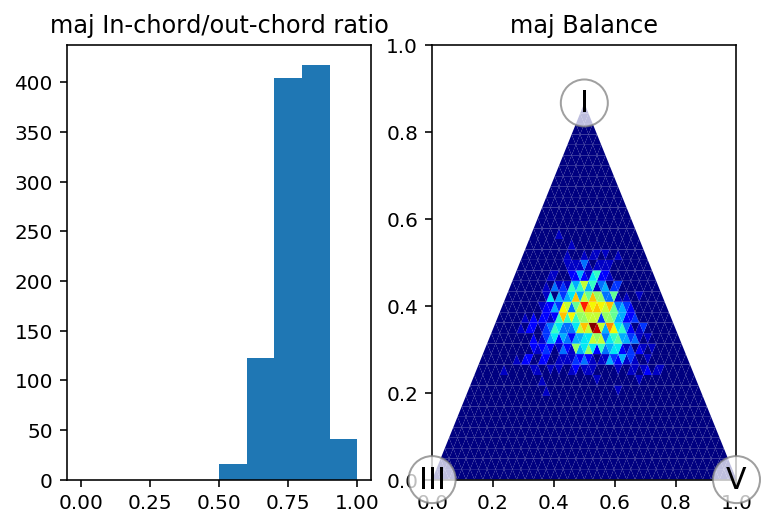

1


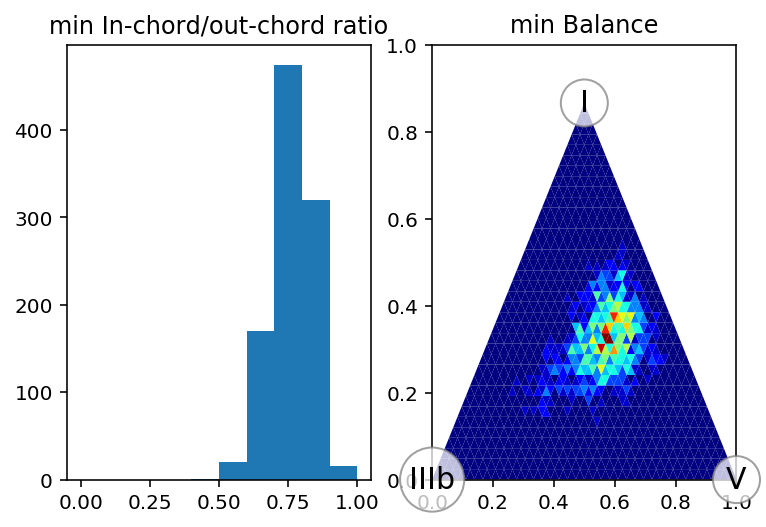

2


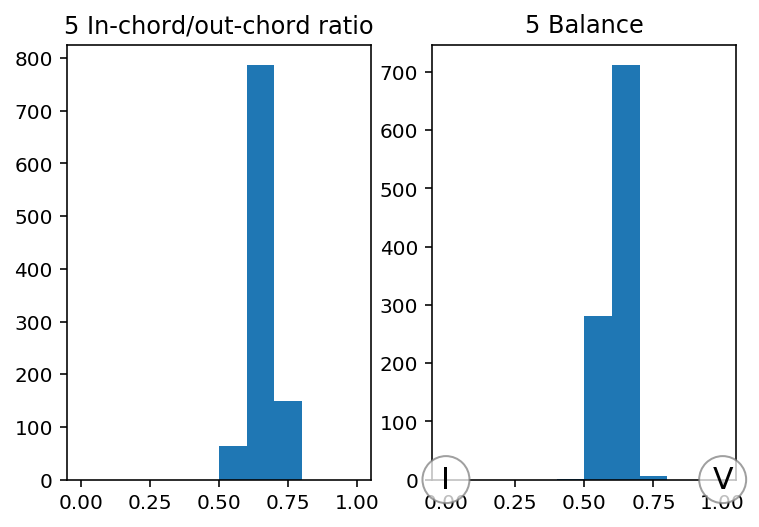

3


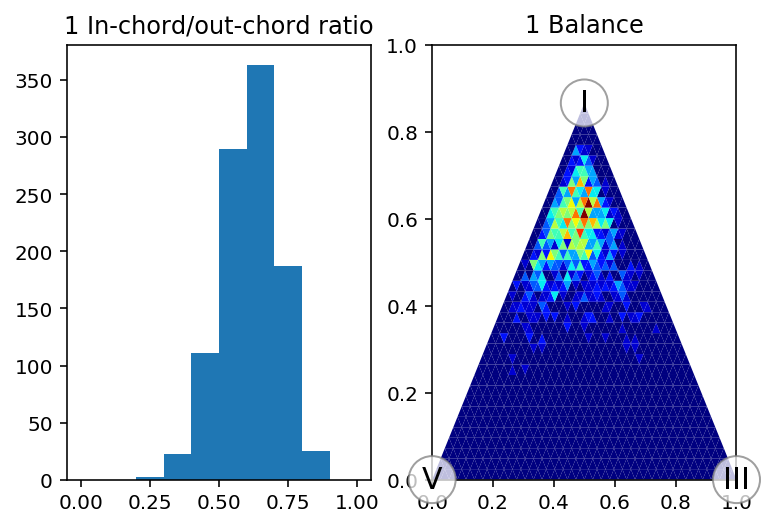

In [6]:
m = joblib.load(model_path + model_name + '.pkl')
for k in range(len(m.kinds)):
    print(k)
    visualize(m, k)

### Test model performance not considering third intervals
* Here we are going to test the model performance using the Raw part of the Five Guitar dataset, filtering out the major/minor third intervals

In [7]:
dataset_path = '../Databases/'
loader_name = 'Loaders/Raw_database.json'

loader = SEGMENTS_LOADER(dataset_path)
test_segments = loader.load_chromas_for_dataset(ex_2_id,loader_name, roll_to_c = False, segments = None)

with open(dataset_path+ loader_name) as af:
    test_audios = json.load(af)

Loaded 90 files.

--->>>The train segments  loading took 0.03 s to compute.


In [8]:
#Filtering third intervals
for i, k in enumerate(test_segments.kinds):
    if k == '+3' or k == '-3':
        test_segments.kinds[i] = 'unclassified'

is_defined = [x != 'unclassified' for x in test_segments.kinds]
test_segments = AnnotatedChromaSegments(
    test_segments.labels[is_defined],
    test_segments.pitches[is_defined],
    test_segments.kinds[is_defined],
    test_segments.chromas[is_defined],
    test_segments.uids[is_defined],
    test_segments.start_times[is_defined],
    test_segments.durations[is_defined])

In [9]:
print('Test set has {} chromas.'.format(test_segments.chromas.shape[0]))

for k in ['maj','min','1','5','+3','-3']:
    print('{} -> Num chromas: {}'.format(k,len(test_segments.chromas[test_segments.kinds == k])))

Test set has 8985 chromas.
maj -> Num chromas: 1290
min -> Num chromas: 1080
1 -> Num chromas: 5835
5 -> Num chromas: 780
+3 -> Num chromas: 0
-3 -> Num chromas: 0


Performance and Accuracy

In [10]:
# Predict pitch class set
m = joblib.load(model_path + model_name + '.pkl')

pred = m.predict(test_segments.chromas)
pred = [str(p) for p in pred[0]]

#Normalize labels to match the format of the predictions
test_segments.labels = [x.replace('(','') for x in test_segments.labels]
test_segments.labels = [x.replace(')','') for x in test_segments.labels]

for i,p in enumerate(test_segments.labels):
    if '1,3' in p:
        test_segments.labels[i] = test_segments.labels[i].replace('1,3','+3')
    elif '1,b3' in p:
        test_segments.labels[i] = test_segments.labels[i].replace('1,b3','-3')
    else:
        pass
    
    if 'maj' in test_segments.kinds[i]:
        if ':maj' not in test_segments.labels[i]:
            test_segments.labels[i] = test_segments.labels[i]+':maj'

Accuracy: 0.8676


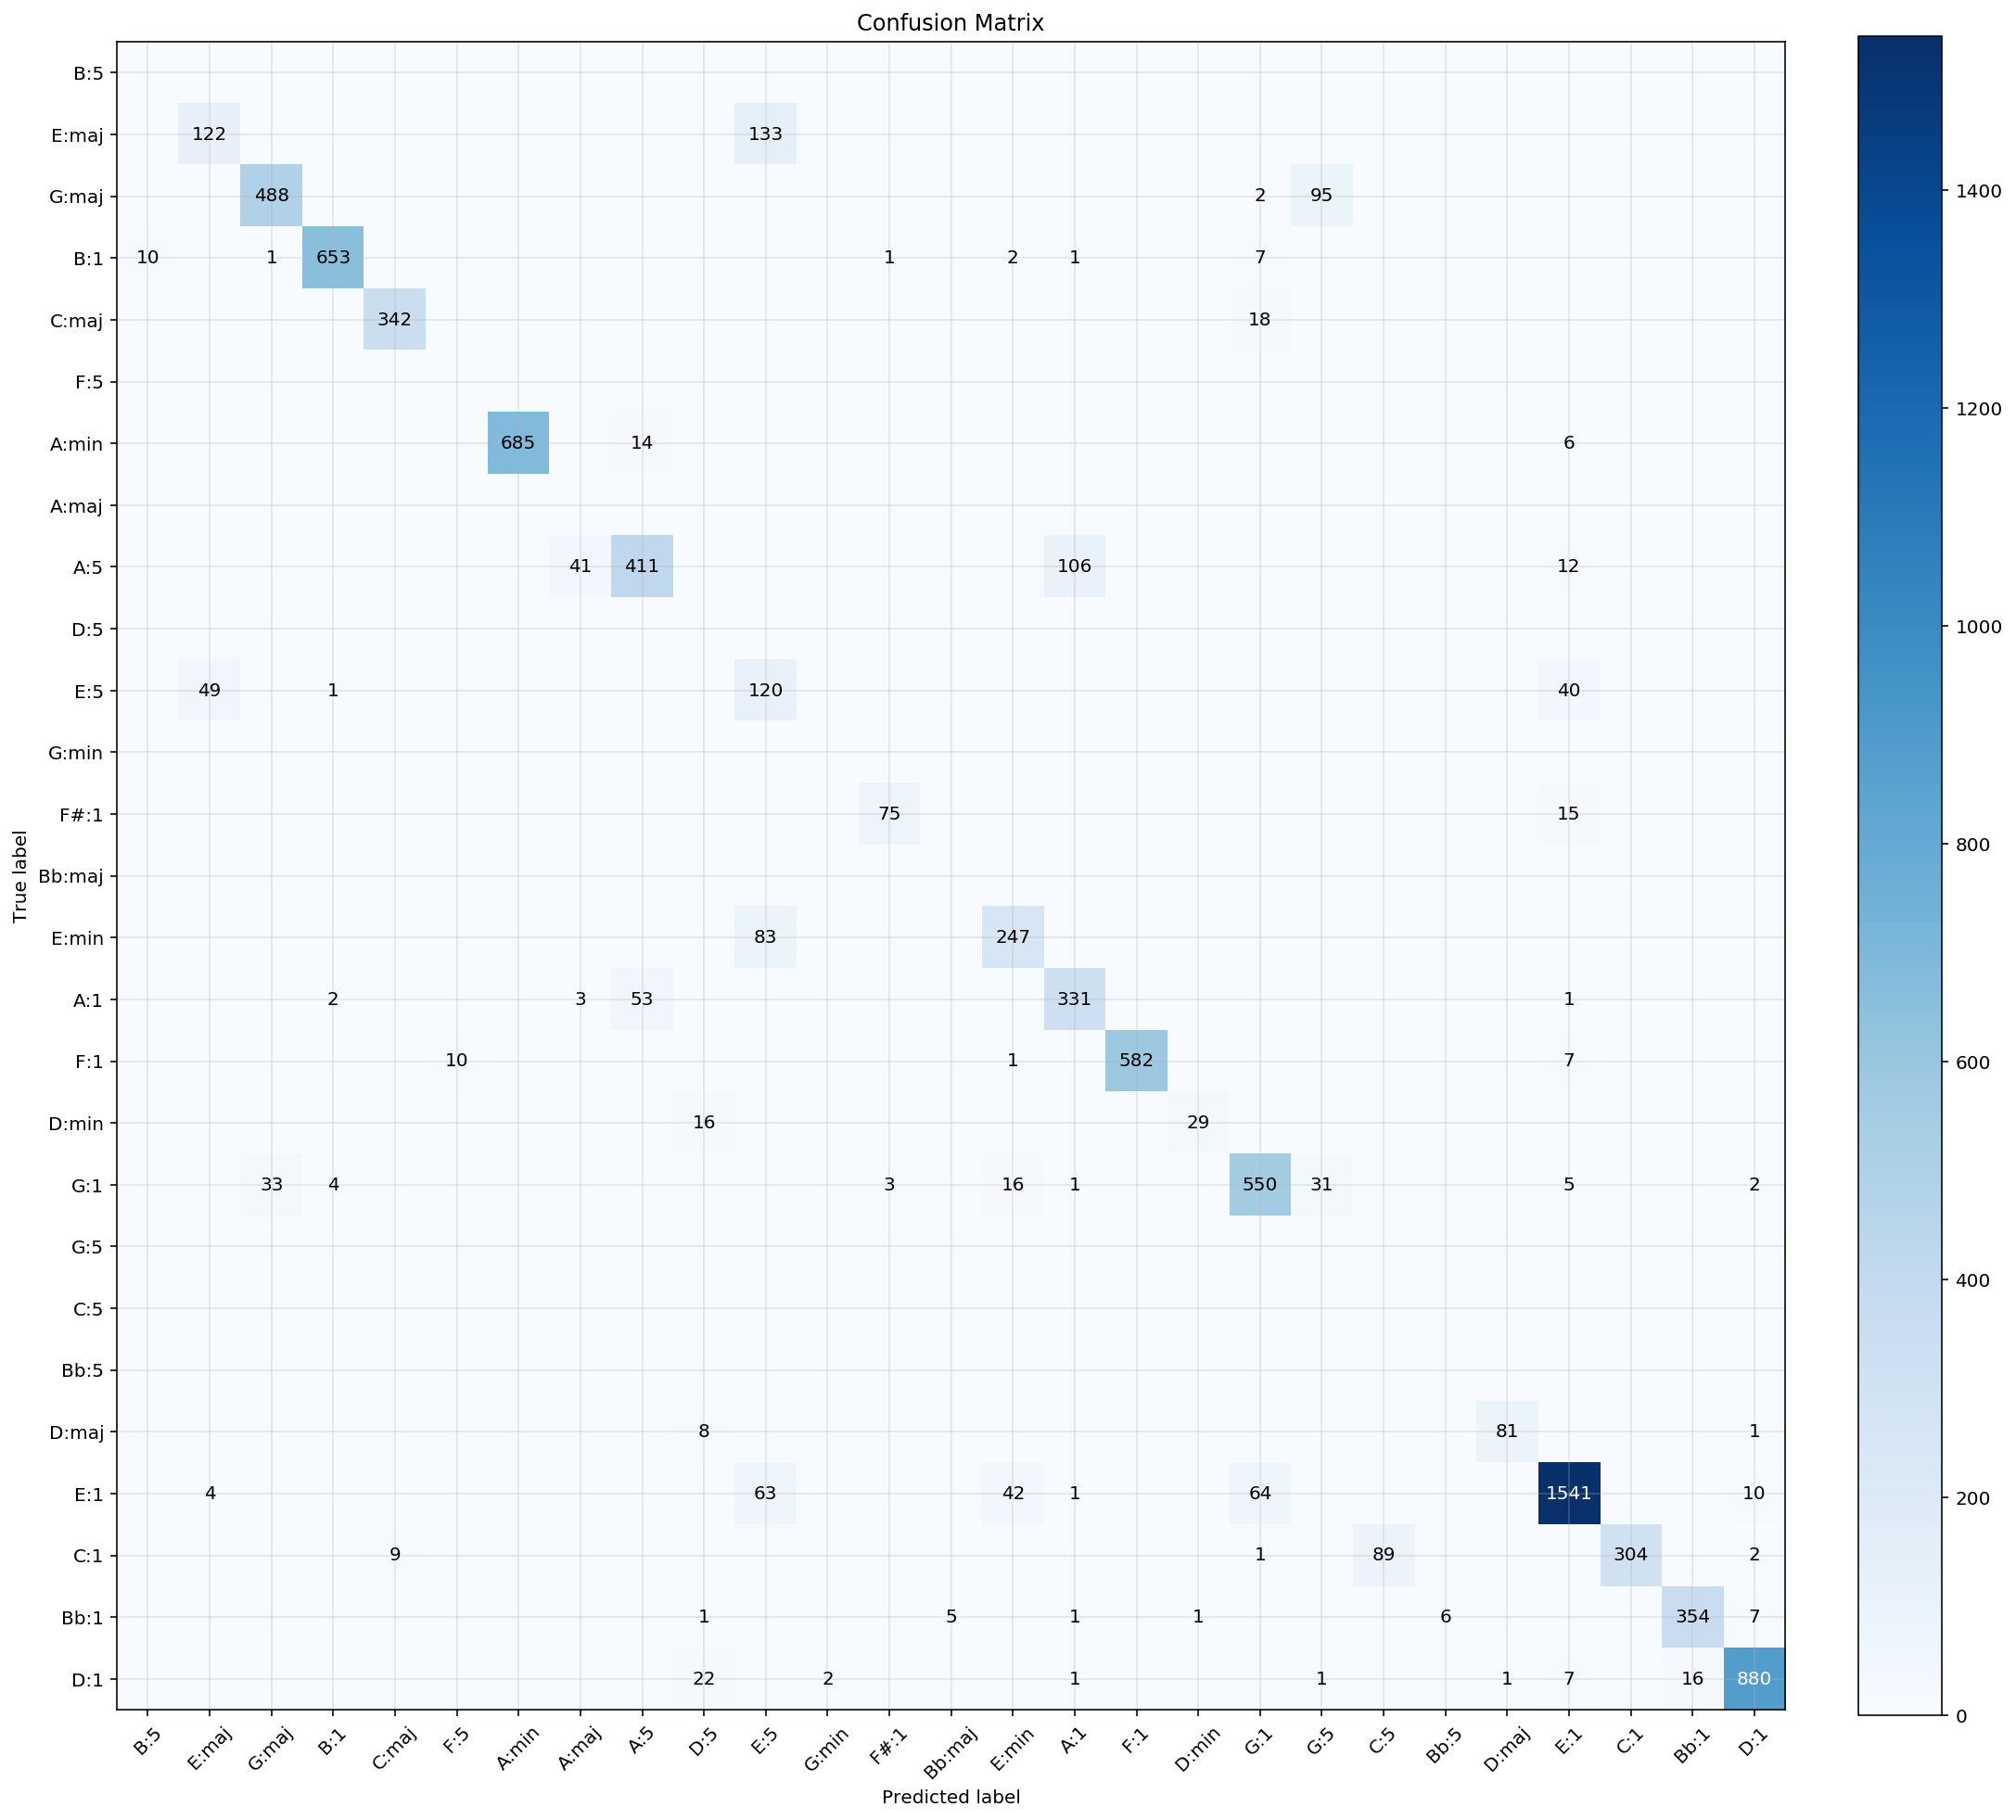

In [11]:
# Pitch class set metrics
OM = Overall_Metrics(test_segments.labels , pred)

OM.accuracy()

cm  =OM.conf_matrix()

Accuracy: 0.8853


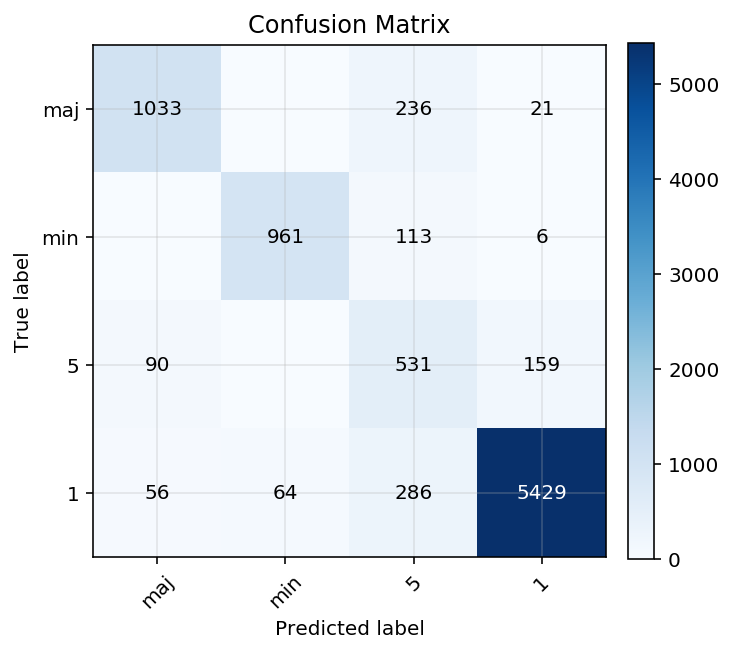

In [12]:
# Kind metrics
KM = Kind_Metrics(test_segments.kinds,pred, labels = ['maj','min','5','1'])

KM.accuracy()

cm = KM.conf_matrix()

# Test model performance considering third intervals
* Here we are going to use the same test set without filtering major/minor third intervals.

In [13]:
dataset_path = '../Databases/'
loader_name = 'Loaders/Raw_database.json'

loader = SEGMENTS_LOADER(dataset_path)
test_segments = loader.load_chromas_for_dataset(ex_2_id,loader_name, roll_to_c = False, segments = None)

with open(dataset_path+ loader_name) as af:
    test_audios = json.load(af)
    
is_defined = [x != 'unclassified' for x in test_segments.kinds]
test_segments = AnnotatedChromaSegments(
    test_segments.labels[is_defined],
    test_segments.pitches[is_defined],
    test_segments.kinds[is_defined],
    test_segments.chromas[is_defined],
    test_segments.uids[is_defined],
    test_segments.start_times[is_defined],
    test_segments.durations[is_defined])

Loaded 90 files.

--->>>The train segments  loading took 0.04 s to compute.


In [14]:
print('Test set has {} chromas.'.format(test_segments.chromas.shape[0]))

for k in ['maj','min','1','5','+3','-3']:
    print('{} -> Num chromas: {}'.format(k,len(test_segments.chromas[test_segments.kinds == k])))

Test set has 10185 chromas.
maj -> Num chromas: 1290
min -> Num chromas: 1080
1 -> Num chromas: 5835
5 -> Num chromas: 780
+3 -> Num chromas: 540
-3 -> Num chromas: 660


In [15]:
# Predict pitch class set
m = joblib.load(model_path + model_name + '.pkl')

pred = m.predict(test_segments.chromas)
pred = [str(p) for p in pred[0]]

#Normalize labels to match the format of the predictions
test_segments.labels = [x.replace('(','') for x in test_segments.labels]
test_segments.labels = [x.replace(')','') for x in test_segments.labels]

for i,p in enumerate(test_segments.labels):
    if '1,3' in p:
        test_segments.labels[i] = test_segments.labels[i].replace('1,3','+3')
    elif '1,b3' in p:
        test_segments.labels[i] = test_segments.labels[i].replace('1,b3','-3')
    else:
        pass
    
    if 'maj' in test_segments.kinds[i]:
        if ':maj' not in test_segments.labels[i]:
            test_segments.labels[i] = test_segments.labels[i]+':maj'

Accuracy: 0.7653


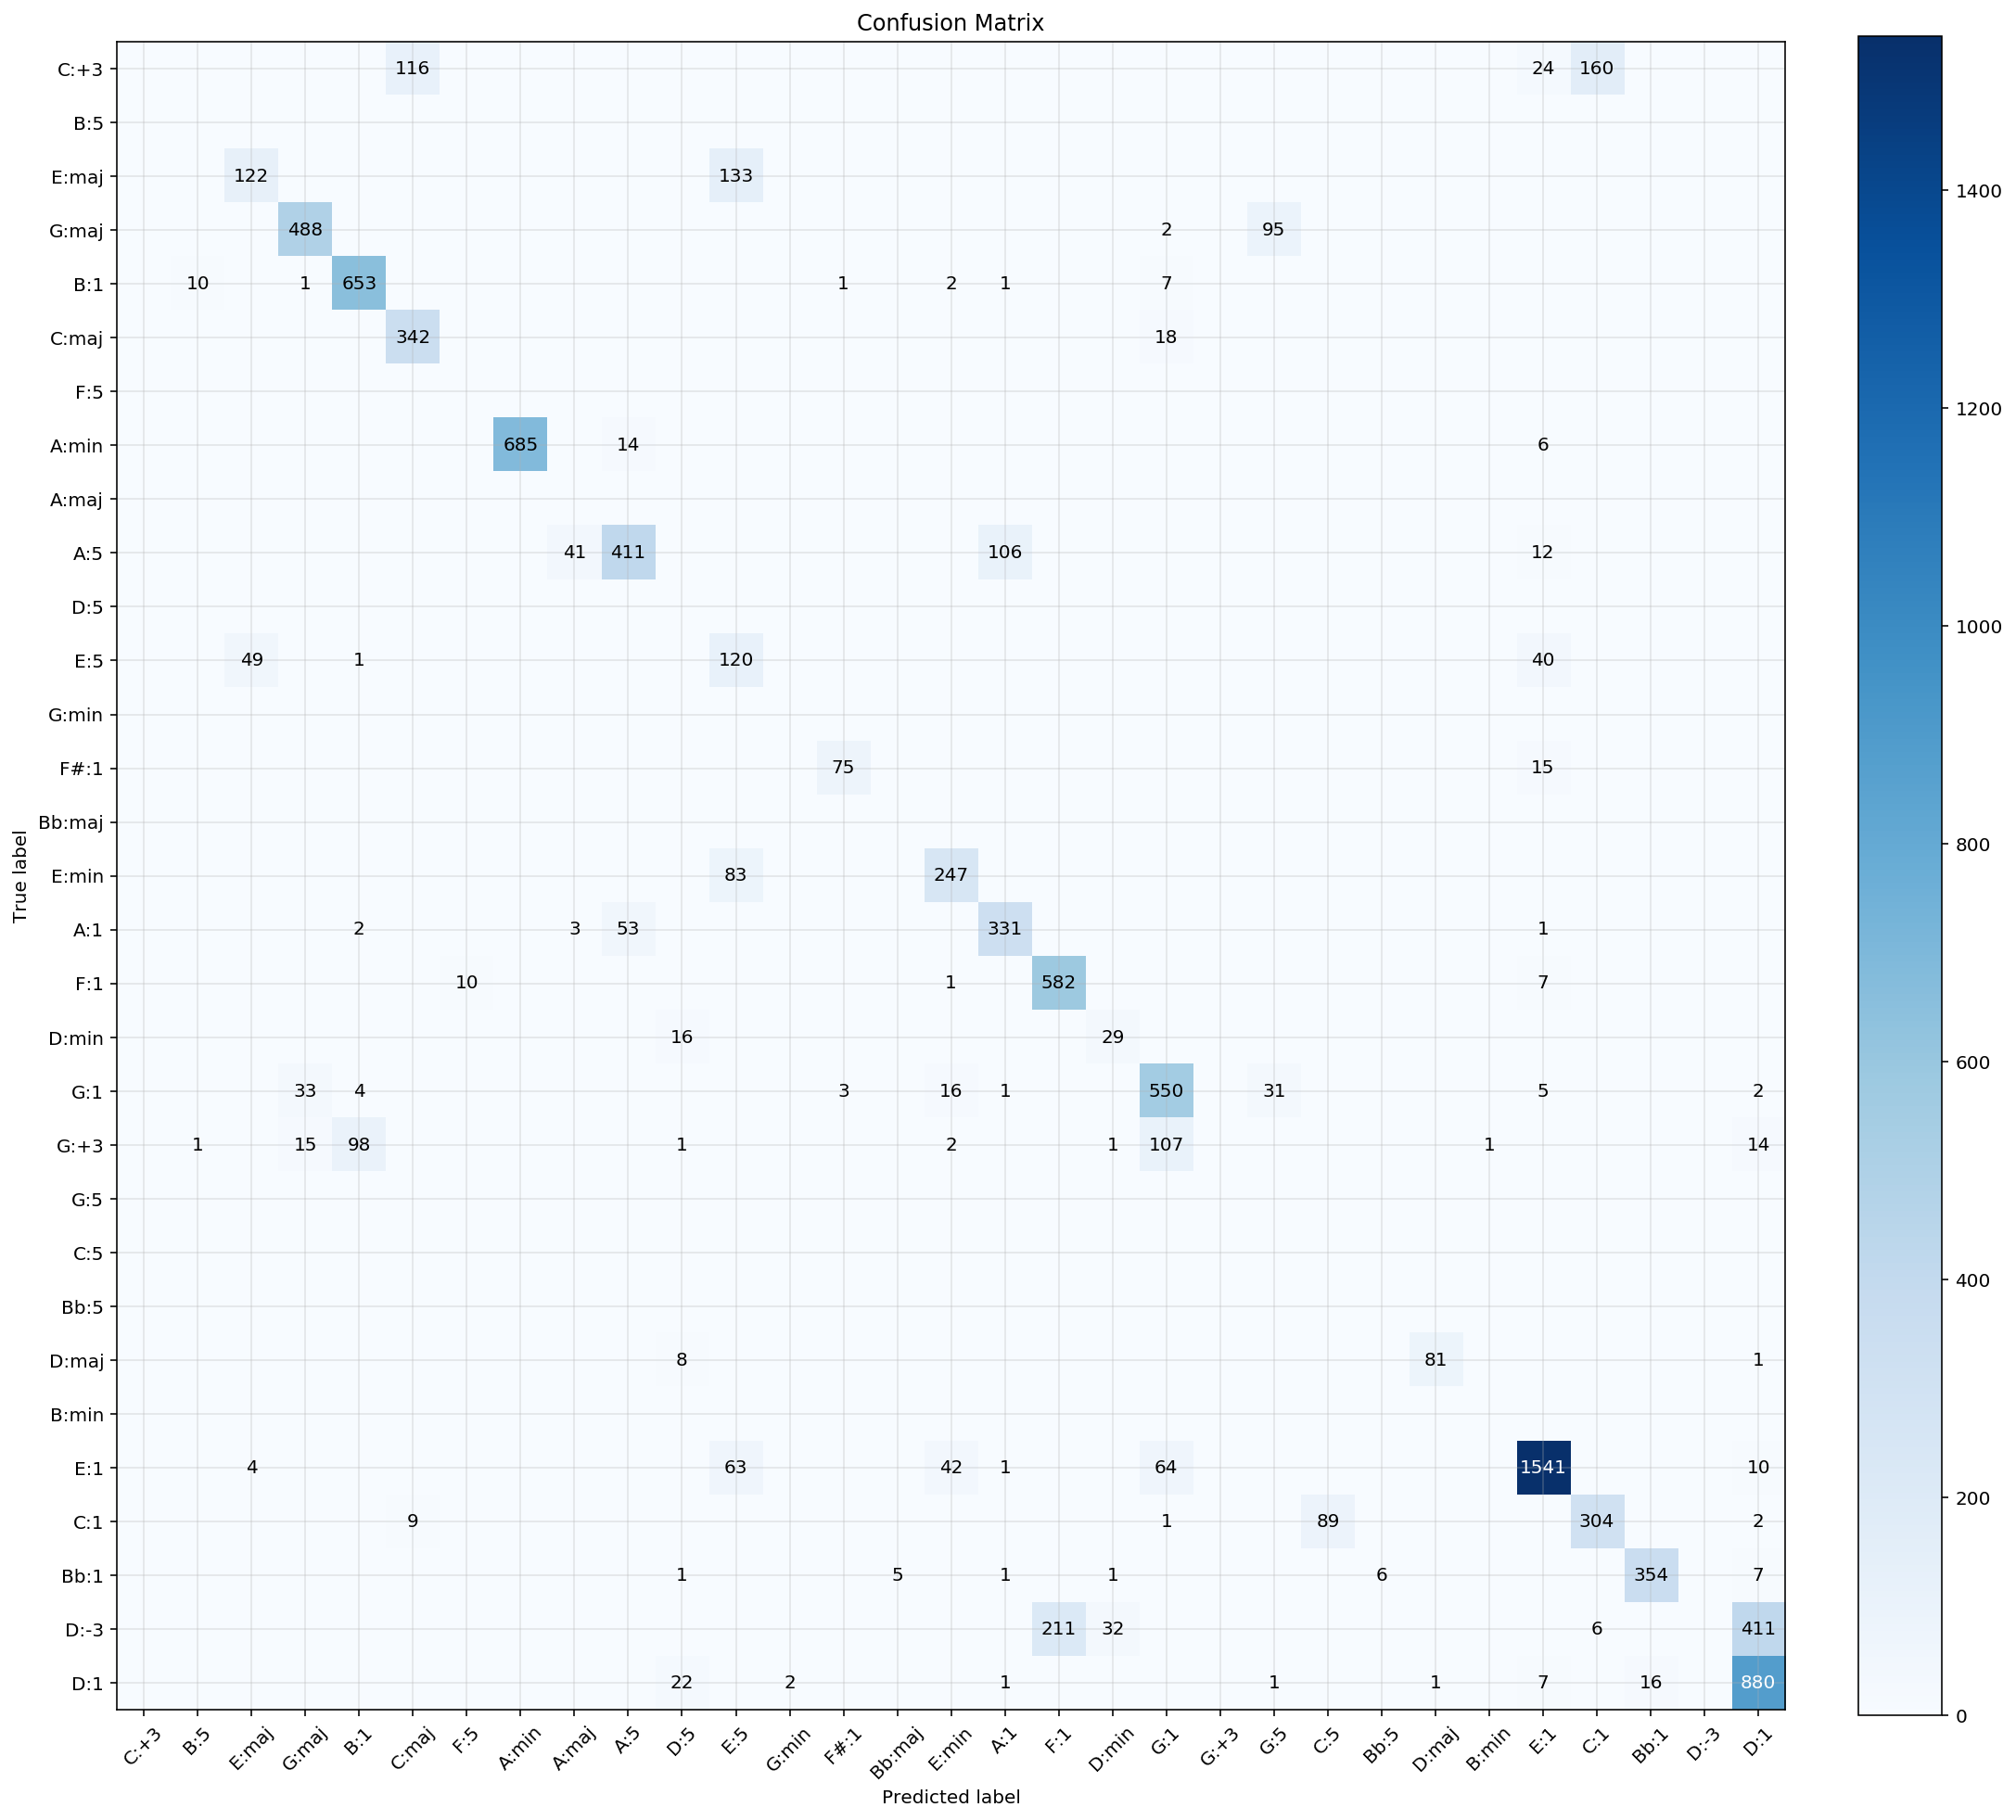

In [16]:
# Pitch class set metrics
OM = Overall_Metrics(test_segments.labels , pred)

OM.accuracy()

cm  =OM.conf_matrix()

Accuracy: 0.781


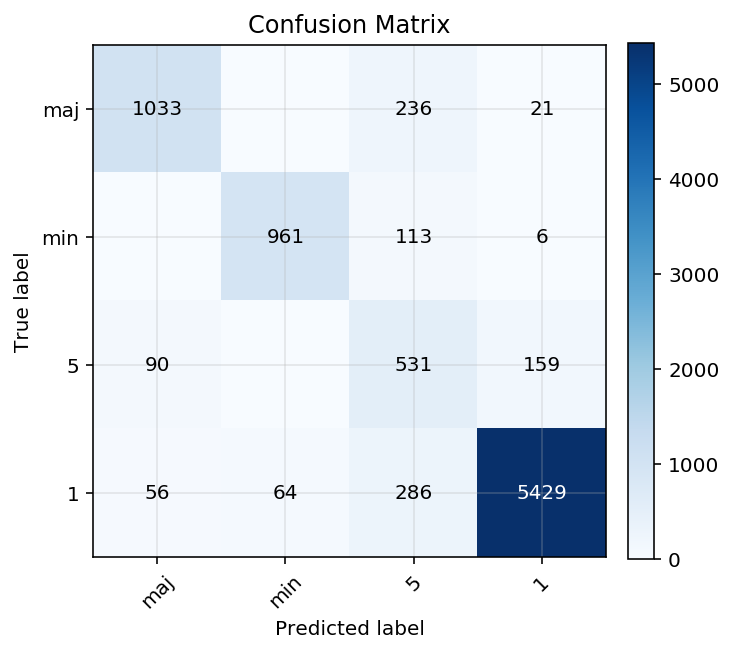

In [17]:
# Kind metrics
KM = Kind_Metrics(test_segments.kinds,pred, labels = ['maj','min','5','1'])

KM.accuracy()

cm = KM.conf_matrix()